<a href="https://colab.research.google.com/github/Konerusudhir/machine_learning_exercises/blob/master/MP_ART_Classifier_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
# # Installs
# !pip install transformers # Hugging Face Models
# !pip install matplotlib # Plot images and graphs
# !pip install gradio # Web app
# !pip install tensorboard
%load_ext tensorboard

In [2]:
import os
import shutil
import math 
import glob
import json
import pickle
import requests
import time
import re
import string
from datetime import datetime

import pandas as pd
import numpy as np
from PIL import Image

# Display libs
from IPython.display import display
from struct import unpack
from tqdm import tqdm

import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
ROOT_FOLDER = "wikiart_classifier"
DATA_FOLDER = os.path.join(ROOT_FOLDER, "data")
IMAGES_FOLDER = os.path.join(ROOT_FOLDER, "images")
LOGS_DIR = os.path.join(ROOT_FOLDER, "logs")
PRE_TRAINED_MODELS_DIR = os.path.join(ROOT_FOLDER, "pre_trained_models")
TRAINED_MODELS = os.path.join(ROOT_FOLDER, "trained_models")

def clean_directories():
    # shutil.rmtree(DATA_FOLDER, ignore_errors=True)  
    # shutil.rmtree(IMAGES_FOLDER, ignore_errors=True)
    # shutil.rmtree(PRE_TRAINED_MODELS_DIR, ignore_errors=True)
    shutil.rmtree(LOGS_DIR, ignore_errors=True)
    # shutil.rmtree(TRAINED_MODELS, ignore_errors=True)


clean_directories()  

def create_directories():
    if not os.path.exists(DATA_FOLDER):
        os.mkdir(DATA_FOLDER) 
    if not os.path.exists(IMAGES_FOLDER):
        os.mkdir(IMAGES_FOLDER) 
    if not os.path.exists(LOGS_DIR):
        os.mkdir(LOGS_DIR)
    if not os.path.exists(PRE_TRAINED_MODELS_DIR):
        os.mkdir(PRE_TRAINED_MODELS_DIR)
    if not os.path.exists(TRAINED_MODELS):
        os.mkdir(TRAINED_MODELS)


create_directories()

def get_logs_dir(model_name):
  run_timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
  return f"{LOGS_DIR}/{model_name}/{run_timestamp}"

In [4]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id , 'confirm': 1 }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# wikiart_images_file_id = '1vTChp3nU5GQeLkPwotrybpUGUXj12BTK'
# wikiart_images_local_file_path = os.path.join(DATA_FOLDER, "wikiart.zip")
# if not os.path.exists(wikiart_images_local_file_path):
#     download_file_from_google_drive(
#         wikiart_images_file_id, 
#         wikiart_images_local_file_path)

wikiart_labels_csv_file_id = '1uug57zp13wJDwb2nuHOQfR2Odr0hh1a8'
wikiart_labels_csv_local_file_path = os.path.join(DATA_FOLDER, "labels.zip")
if not os.path.exists(wikiart_labels_csv_local_file_path):
    download_file_from_google_drive(
        wikiart_labels_csv_file_id, 
        wikiart_labels_csv_local_file_path)
if not os.path.exists(os.path.join(DATA_FOLDER, "genre_train.csv")):    
    shutil.unpack_archive(wikiart_labels_csv_local_file_path, DATA_FOLDER, 'zip')

# import deeplake
# import torch
# from torchvision import transforms, models

# dataset_path = 'hub://activeloop/wiki-art'
# ds = deeplake.copy(dataset_path, DATA_FOLDER, num_workers=8, overwrite=True ) # Returns a Deep Lake Dataset but does not download data locally
# # ds = deeplake.load(DATA_FOLDER)
# ds.visualize()


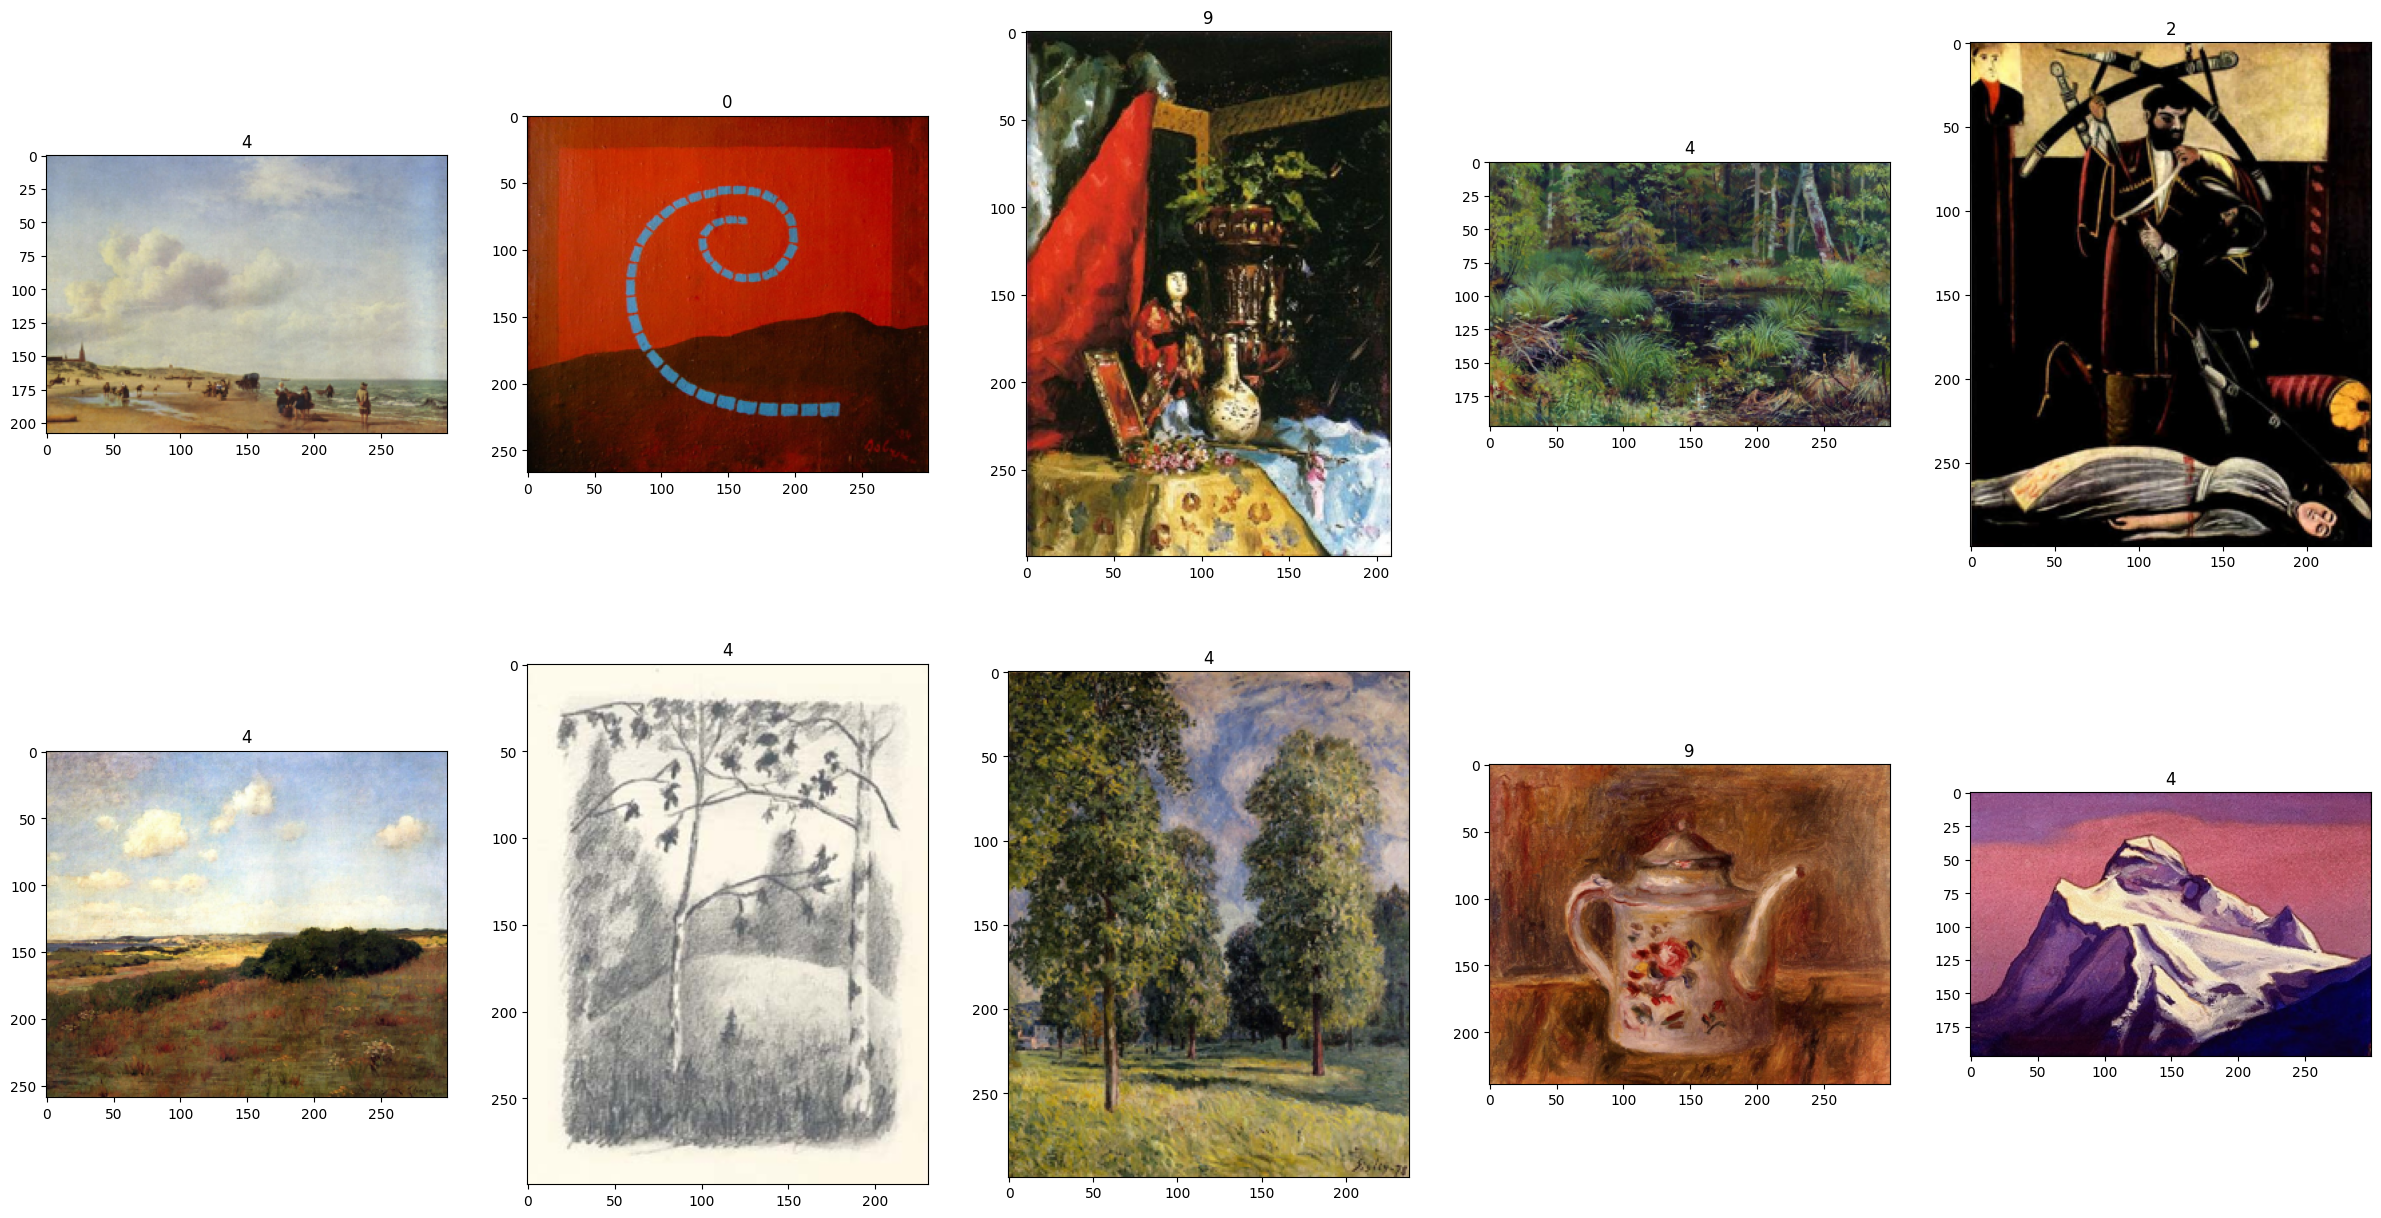

In [5]:
IMAGES_PREFIX = os.path.join(DATA_FOLDER, 'wikiart')
LABELS_PREFIX = os.path.join(DATA_FOLDER)

genre_classes_path = os.path.join(LABELS_PREFIX,'genre_class.txt')
genre_raw_train_path = os.path.join(LABELS_PREFIX,'genre_train.csv')
genre_raw_val_path = os.path.join(LABELS_PREFIX,'genre_val.csv')


# TSV headers [id, class]
genre_classes_df = pd.read_csv(genre_classes_path, sep = ' ')
# print(genre_train_df.iloc[:,1])
genre_classes = {}
for index, row in genre_classes_df.iterrows():
    genre_classes[row[0]] = row[1]

csv_headers = ['image_path', 'label']
csv_types = {'image_path': 'string', 'label': np.int32}
genre_raw_train_df = pd.read_csv(
    genre_raw_train_path, 
    names=csv_headers,
    dtype=csv_types)
genre_raw_train_sample_df = genre_raw_train_df.sample(n=10)

genre_raw_val_df = pd.read_csv(
    genre_raw_val_path, 
    names=csv_headers,
    dtype=csv_types)


def get_img_local_path(suffix):
    return os.path.join(IMAGES_PREFIX, suffix)

def load_resized_image(img_path, max_width = 300, max_height = 300):
    try:
        # print(img_path)
        if 'http' in img_path:
            response = requests.get(img_path, stream=True)
            img = Image.open(requests.get(img_path, stream=True).raw)
        else:    
            img = Image.open(img_path).convert('RGB')
        width, height = img.size
        if width > max_width or height > max_height:
            img.thumbnail((max_width, max_height))
        img = np.asarray(img)
        return img    
    except Exception as e:
        print(f"Error Loading path :{img_path} - {e}") 
        return None

# print(len(genre_raw_train_sample_df.index))
rows=2
cols=5
img_count = 0
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30,15))
for i in range(rows):
    for j in range(cols):
        if img_count < len(genre_raw_train_sample_df.index):
            row_data = genre_raw_train_sample_df.iloc[img_count]
            suffix, label = row_data
            
            axes[i, j].set_title(label)
            axes[i, j].imshow(load_resized_image(get_img_local_path(suffix)))
        img_count+=1 


# Clean Data

In [6]:
%%time
genre_clean_train_path = os.path.join(LABELS_PREFIX, 'genre_clean_train.csv')
genre_clean_val_path = os.path.join(LABELS_PREFIX, 'genre_clean_val.csv')

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

def filter_bad_images(input_df):
    size = len(input_df.index)
    # print(f"Size:{size}")
    # genre_train_df['one'].tolist()
    for i in tqdm(range(size)):
        suffix = input_df.iloc[i][0]
        image_path = get_img_local_path(suffix)
        image = JPEG(image_path) 
        try:
            image.decode()   
        except:
            # print(f"Bad IMage Path:{image_path}")
            bad_images.add(suffix)

    # print(f"Df contains {len(bads)} Bad Images")

# Find Bad JPEGs
bad_images = set()
filter_bad_images(genre_raw_train_df)
filter_bad_images(genre_raw_val_df)
print(f"""
Raw Train Size: {len(genre_raw_train_df.index)} 
Raw Val Size:{len(genre_raw_val_df.index)} 
Bads:{len(bad_images)}
""")

# Remvoe bad JPEGs from Input df and remove Nulls
genre_clean_train_df = genre_raw_train_df[
    ~genre_raw_train_df.image_path.isin(bad_images)].dropna()
genre_clean_val_df = genre_raw_val_df[
    ~genre_raw_val_df.image_path.isin(bad_images)].dropna()
print(f"""
Cleaned Train Size: {len(genre_clean_train_df.index)} 
Cleaned Val Size:{len(genre_clean_val_df.index)}
Bads:{len(bad_images)}""")

# Save cleaned data
genre_clean_train_df.to_csv(
    path_or_buf=genre_clean_train_path, 
    header = False,
    index = False)
genre_clean_val_df.to_csv(
    path_or_buf=genre_clean_val_path, 
    header = False,
    index = False)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 19492/19492 [00:09<00:00, 1970.06it/s]



Raw Train Size: 45503 
Raw Val Size:19492 
Bads:313


Cleaned Train Size: 45301 
Cleaned Val Size:19381
Bads:313
CPU times: user 9.26 s, sys: 12.8 s, total: 22 s
Wall time: 34.3 s


In [7]:
%%time
from transformers import CLIPTokenizer, CLIPImageProcessor, TFCLIPTextModel, TFCLIPVisionModel


clip_model_id = "openai/clip-vit-large-patch14"

vision_model = TFCLIPVisionModel.from_pretrained(clip_model_id, cache_dir=PRE_TRAINED_MODELS_DIR)
vision_processor = CLIPImageProcessor.from_pretrained(clip_model_id)

# text_model = TFCLIPTextModel.from_pretrained(clip_model_id)
# tokenizer = CLIPTokenizer.from_pretrained(clip_model_id)

/usr/local/anaconda3/envs/semantic_search/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-29 15:12:59.117322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-29 15:12:59.117377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


Some layers from the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing TFCLIPVisionModel: ['clip/text_model/encoder/layers_._3/mlp/fc1/kernel:0', 'clip/text_model/encoder/layers_._5/self_attn/out_proj/bias:0', 'clip/text_model/encoder/layers_._8/mlp/fc1/kernel:0', 'clip/text_model/encoder/layers_._3/self_attn/v_proj/bias:0', 'clip/text_model/encoder/layers_._2/mlp/fc1/bias:0', 'clip/text_model/encoder/layers_._6/self_attn/q_proj/kernel:0', 'clip/text_model/encoder/layers_._11/mlp/fc1/bias:0', 'clip/text_model/encoder/layers_._3/layer_norm1/beta:0', 'clip/text_model/encoder/layers_._3/self_attn/out_proj/kernel:0', 'clip/text_model/encoder/layers_._8/self_attn/q_proj/bias:0', 'clip/text_model/encoder/layers_._11/layer_norm2/beta:0', 'clip/text_model/encoder/layers_._1/mlp/fc1/bias:0', 'clip/text_model/encoder/layers_._10/self_attn/out_proj/bias:0', 'clip/text_model/encoder/layers_._4/self_attn/q_proj/bias:0', 'clip/text_model/encoder/layers_._2/self_attn/q

CPU times: user 1.34 s, sys: 703 ms, total: 2.04 s
Wall time: 3.46 s


In [8]:
BATCH_SIZE=50

def load_image_dataset(data_file_path):
    current_dataset = tf.data.TextLineDataset([data_file_path])
    # current_dataset = tf.data.Dataset.from_tensor_slices(dataframe)


    def decode_csv_line(line):
        return tf.io.decode_csv(line, [str(), int()])
    current_csv_dataset = current_dataset.map(decode_csv_line)  
    
    # def filter_bad_image(image_path, label):
    #     return tf.sets.size(tf.sets.difference(image_path, bads)) > 0
    # filtered_dataset = current_csv_dataset.map(filter_bad_image)  

    def load_image_objects(image_path, label):
        local_path = tf.strings.join(
            inputs = [IMAGES_PREFIX,image_path],
            separator = '/'
        )
        # print(f"{local_path}, {label}")
        
        # path/label represent values for a single example
        decoded_image = tf.io.decode_image(
            contents = tf.io.read_file(local_path),
            channels = 3,
            expand_animations = False
        )

        resized_image = tf.image.resize_with_pad(
            image = decoded_image, 
            target_height = 224,
            target_width = 224,
        )
        # resized_image = tf.image.resize(
        #     images = decoded_image, 
        #     size = [224, 224],
        #     preserve_aspect_ratio = True
        # )
        
        transposed_image = tf.transpose(
            resized_image)
        # resized_image = vision_processor(
        #     images=tf.io.read_file(local_path), 
        #     return_tensors="tf"
        # )
        # transposed_image = vision_processor(
        #     images=decoded_image, 
        #     return_tensors="tf")

        print(f"Decoded Shape:{decoded_image.shape}")
        print(f"Resized Shape:{resized_image.shape}")
        print(f"Transposed Shape:{transposed_image.shape}")

        print(resized_image)
        print(transposed_image)
        
        return [transposed_image, label]
    current_image_dataset = current_csv_dataset.map(load_image_objects)

    def configure_for_performance(ds):
        ds = ds.cache()
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
        return ds
    return configure_for_performance(current_image_dataset)

train_dataset = load_image_dataset(genre_clean_train_path)
for example in train_dataset.take(1):
    print([e.numpy() for e in example])
    # print('a')

val_dataset = load_image_dataset(genre_clean_val_path)
for example in val_dataset.take(1):
  print([e.numpy() for e in example])



Decoded Shape:(None, None, 3)
Resized Shape:(224, 224, 3)
Transposed Shape:(3, 224, 224)
Tensor("resize_image_with_pad/Squeeze:0", shape=(224, 224, 3), dtype=float32)
Tensor("transpose:0", shape=(3, 224, 224), dtype=float32)


2022-12-29 15:13:01.517507: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[array([[[[  0.      ,   0.      ,   0.      , ...,   0.      ,
            0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      , ...,   0.      ,
            0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      , ...,   0.      ,
            0.      ,   0.      ],
         ...,
         [  0.      ,   0.      ,   0.      , ...,   0.      ,
            0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      , ...,   0.      ,
            0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      , ...,   0.      ,
            0.      ,   0.      ]],

        [[  0.      ,   0.      ,   0.      , ...,   0.      ,
            0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      , ...,   0.      ,
            0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      , ...,   0.      ,
            0.      ,   0.      ],
         ...,
         [  0.      ,   0.      ,   0.      , ...,   0.      ,
            0.      ,   

2022-12-29 15:13:04.807379: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       

2022-12-29 15:13:07.820177: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [19]:
%%time
base_learning_rate = 0.0001
steps_per_execution = 200

def create_classification_model():
    
    # Preprocess images
    inputs = tf.keras.Input(shape=(3, 224, 224))
    rescaling_layer = tf.keras.layers.Rescaling(1.0/255, offset=0.0)
    rescaled_input = rescaling_layer(inputs)
    # processed_inputs = vision_processor(images=[inputs], return_tensors="tf")
    # print(inputs)
    
    vision_model.trainable=False
    # vision_model.trainable = True
    # # Fine-tune from this layer onwards
    # fine_tune_at = 100

    # # Freeze all the layers before the `fine_tune_at` layer
    # for layer in base_model.layers[:fine_tune_at]:
    # layer.trainable = False
    base_model_output = vision_model(rescaled_input)
    
    current_layer = base_model_output.pooler_output
    hidden_layers_nodes = [64]
    for node_count in hidden_layers_nodes:
        hidden_layer = tf.keras.layers.Dense(node_count, activation='relu')
        dropout_layer = tf.keras.layers.Dropout(.2, input_shape=(2,))
        # hidden_layer.trainable = False
        current_layer = hidden_layer(dropout_layer(current_layer))
    
    prediction_layer = tf.keras.layers.Dense(9, activation='softmax')
    # prediction_layer.trainable = False
    outputs = prediction_layer(current_layer)
    model = tf.keras.Model(inputs, outputs)

        
    model.compile(
        # Used leagcy optimizer due to tf 2.11 release issues with MACOS 
        # optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
        steps_per_execution=steps_per_execution
    )

    return model



model = create_classification_model()
model.summary()
# print(outputs.pooler_output.shape)



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 224, 224)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 3, 224, 224)       0         
                                                                 
 tfclip_vision_model (TFCLIP  TFBaseModelOutputWithPoo  303179776
 VisionModel)                ling(last_hidden_state=(            
                             None, 257, 1024),                   
                              pooler_output=(None, 10            
                             24),                                
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 dropout_49 (Dropout)        (None, 1024)              0   

In [10]:
# Launch Tensorboard before training
%tensorboard --logdir 'logs'
# %tensorboard --logdir 'logs' --no-open

In [15]:
ONE_EPOCH_STEPS = int(65000/BATCH_SIZE/steps_per_execution)
APPROX_EPOCHS = ONE_EPOCH_STEPS*2
VALIDATION_STEPS = 10
PATIENCE=ONE_EPOCH_STEPS
weights_file = os.path.join(TRAINED_MODELS,"best_weights")

logdir=get_logs_dir("neural_network")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=PATIENCE)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weights_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)

callbacks = [
    early_stopping_callback, 
    model_checkpoint_callback, 
    tensorboard_callback] 

if os.path.exists(f"{weights_file}.index"):
    # Find latest saved checkpoint weights and evaluate
    latest_weights = tf.train.latest_checkpoint(TRAINED_MODELS)
    model.load_weights(latest_weights)
    model.evaluate(
        x = val_dataset, 
        # steps_per_epoch=steps_per_execution,
        steps=VALIDATION_STEPS,
        callbacks=callbacks)

history = model.fit(
    x=train_dataset,
    steps_per_epoch=steps_per_execution,
    validation_steps=VALIDATION_STEPS,
    epochs=APPROX_EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks
)

10/10 [==============================] - 25s 3s/step - loss: 0.8007 - accuracy: 0.7000
Epoch 1/12


2022-12-29 17:29:10.747299: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


200/200 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.7418

2022-12-29 17:37:37.100324: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


200/200 [==============================] - 510s 3s/step - loss: 0.6096 - accuracy: 0.7418 - val_loss: 0.7903 - val_accuracy: 0.7000
Epoch 2/12
200/200 [==============================] - 509s 3s/step - loss: 0.6162 - accuracy: 0.7436 - val_loss: 1.0046 - val_accuracy: 0.6320
Epoch 3/12


2022-12-29 17:46:09.165730: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


200/200 [==============================] - 529s 3s/step - loss: 0.5891 - accuracy: 0.7513 - val_loss: 0.9517 - val_accuracy: 0.6340
Epoch 4/12


2022-12-29 17:54:57.764975: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


200/200 [==============================] - 532s 3s/step - loss: 0.5888 - accuracy: 0.7534 - val_loss: 0.8944 - val_accuracy: 0.6540
Epoch 5/12


2022-12-29 18:03:49.486519: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2022-12-29 18:08:42.301650: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


200/200 [==============================] - 296s 1s/step - loss: 0.6052 - accuracy: 0.7455 - val_loss: 0.7090 - val_accuracy: 0.7440


In [16]:
# Find latest saved checkpoint weights and evaluate
latest_weights = tf.train.latest_checkpoint(TRAINED_MODELS)
model.load_weights(latest_weights)
model.evaluate(
    x = val_dataset, 
    # steps_per_epoch=steps_per_execution,
    steps=VALIDATION_STEPS,
    callbacks=callbacks)

10/10 [==============================] - 25s 2s/step - loss: 0.6939 - accuracy: 0.7360


2022-12-29 18:13:12.951359: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[0.6939095258712769, 0.7360000610351562]

In [17]:
saved_model_path = os.path.join(TRAINED_MODELS,"saved_models")
tf.keras.models.save_model(model,saved_model_path)

INFO:tensorflow:Assets written to: wikiart_classifier/trained_models/saved_models/assets


INFO:tensorflow:Assets written to: wikiart_classifier/trained_models/saved_models/assets


In [20]:

loaded_model = create_classification_model()
latest_weights = tf.train.latest_checkpoint(TRAINED_MODELS)
loaded_model.load_weights(latest_weights)
# loaded_model = tf.keras.models.load_model(
#     saved_model_path, custom_objects=None, compile=True, options=None
# )

In [22]:
loaded_model.evaluate(
    x = val_dataset, 
    # steps_per_epoch=steps_per_execution,
    steps=VALIDATION_STEPS*10,
    callbacks=callbacks)

100/100 [==============================] - 234s 2s/step - loss: 0.7240 - accuracy: 0.7358


2022-12-29 18:31:25.558817: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[0.7240488529205322, 0.73580002784729]

In [23]:
print(genre_classes)

{1: 'cityscape', 2: 'genre_painting', 3: 'illustration', 4: 'landscape', 5: 'nude_painting', 6: 'portrait', 7: 'religious_painting', 8: 'sketch_and_study', 9: 'still_life'}
